# 参数化LAT生成、对比器
* 功能：根据给出的经纬度范围和纬度带大小和年份，生成相应的中国陆地区域LAT-XCO2anomaly，并提供与ODIAC的相关系数。
* 约束条件：（1）参数都是整数，即整数优化问题。（2）纬度范围的差需是纬度带大小的倍数。（2）不能使中国陆地掩膜超过最顶层和最底层纬度带的一半（奇纬度带则可以到中间），否则无法被插值，中国陆地掩膜具体的底层索引为108(北纬18~19)，顶层为143(北纬53~54)，对应代码范围应为(108, 144)，条件为(108>=bottom+bandwidth//2)&(144<=top-bandwidth//2)。（3）经度范围需要覆盖中国，陆地掩膜左侧索引为254(东经74~75)，右侧为314(东经134~135)，对应代码范围(254, 315)。

In [1]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from maplot import map_plot_surface, map_plot_surface_sub
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

inPath = "H:\\XCO2\\OCO2_GEOS_L3_v10r\\src_daily_resample\\"
outPath = "H:\\XCO2\\OCO2_GEOS_L3_v10r\\{}\\"  # 待填充新文件夹
odiacPath = "H:\\CO2\\ODIAC\\2022\\year\\"

china = np.load("china_area.npy") > 0.0
globe = np.load("globe.npy")
globe[china] = True
cn_left, cn_right = 74, 135
cnLeft, cnRight = 254, 315  # 右侧实际为314，加1便于运算
cn_bottom, cn_top = 18, 54
cnBottom, cnTop = 108, 144  # 顶端实际为143，加1便于运算

filenames = os.listdir(inPath)
files = {}
odiac_dataset = np.array([np.load(odiacPath+f"ODIAC_{year}.npy") for year in range(2015, 2022)])
for year in range(2015, 2022):
    files[year] = [filename for filename in filenames if filename[20:24]==f"{year}"]
    print(f"Length of {year}: {len(files[year])}")

Length of 2015: 365
Length of 2016: 366
Length of 2017: 365
Length of 2018: 365
Length of 2019: 365
Length of 2020: 366
Length of 2021: 365


In [2]:
def read(name, mask=globe):
    d = nc.Dataset(inPath+name, 'r').variables["XCO2"][:].data[0] * 1e6
    d[~mask] = np.NaN
    return d


# 提前读取，后续只用切片
data_years = {year:np.array([read(f) for f in files[year]]) for year in range(2015, 2022)}


def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
        
"""
func: LAT Generation.
    -- params
        -- lons: Longitude range of the algorithm.
        -- lats: Latitude range of the algorithm.
        -- bandwidth: Width of every latitudinal band, should be able to divide the length of lons exactly.
        -- years: Year range, default: (2015, 2022) (2015~2021).
        -- save_path: default: None.
"""
def lat_gen(lons: tuple, lats: tuple, bandwidth: int, years=(2015, 2022), save_folder=None, inform=True):
    
    mkdir(outPath.format(save_folder))
    
    # 索引
    left = int(lons[0]) + 180
    right = int(lons[1]) + 180  # 实际为加179，加1用于索引和运算
    bottom = int(lats[0]) + 90
    top = int(lats[1]) + 90  # 实际为加89， 加1用于索引和运算
    
    len_lon = right - left
    len_lat = top - bottom
    
    error_flag = False
    if len_lat % bandwidth != 0:  # 整除约束
        print(f"Error> Bandwidth:{bandwidth} doesn't exactly divide Length_of_Lons:{len_lon}.")
        error_flag = True
    if not (cnBottom>=bottom+bandwidth//2 and cnTop<=top-bandwidth//2):  # 底、顶端纬度带半约束
        print(f"Error> Latitude_range:({lats[0]},{lats[1]}) and Bandwidth:{bandwidth} don't conform to the constraint.")
        error_flag = True
    if not (cnLeft>=left and cnRight<=right):  # 经度约束
        print(f"Error> Longitude_range:({lons[0]},{lons[1]}) doesn't conform to the constraint.")
        
    if error_flag:
        return 0.0
    
    num_bands = len_lat // bandwidth  # 纬度带数量

    anomaly = []
    if inform:
        print(f"Process (lons: {lons}; lats: {lats}; bandwidth: {bandwidth}; years: {years}) start.")
    
    for year in range(*years):
        data = data_years[year][:, bottom:top, left:right]  # 切片shape: (~365, lats, lons)
        num_days = data.shape[0]
        
        # 每日文件先变形为天数*纬度带数量*纬度带宽度*经度范围长度，获得一定个数纬度带的中值，shape: (~365, num_bands)
        medians = np.nanmedian(data.reshape(num_days, num_bands, bandwidth, len_lon), axis=(2, 3))
        medians_lat = np.linspace(bandwidth/2, len_lat-bandwidth/2, num_bands)  # shape: (num_bands,)
        f = interp1d(medians_lat, medians)
        # 顶部和底部各半个纬度带无法插值，奇偶纬度带长度通用
        to_interp = np.linspace(bandwidth//2+0.5, len_lat-bandwidth//2-0.5, len_lat-bandwidth//2*2)
        nan_rows = np.full((num_days, bandwidth//2), np.nan)  # 填充矩阵
        bck = np.broadcast_to(np.concatenate((nan_rows, f(to_interp), nan_rows), axis=1)[:, :, np.newaxis],
                              (num_days, len_lat, len_lon))  # shape: (n, 高, 宽)，插值、填充后广播到经度上
        
        global_map = np.full((180, 360), np.NaN)
        global_map[bottom:top, left:right] = np.nanmean(data - bck, axis=0)  # 填充至全球
        global_map[~china] = np.NaN
        anomaly.append(global_map)
        if save_folder:
            np.save(outPath.format(save_folder)+f"MappingXCO2_{year}.npy", global_map)
    
    # 计算与ODIAC之间的相关系数r
    num_years = years[1] - years[0]
    expand_china = np.expand_dims(china, axis=0).repeat(num_years, axis=0)
    anomaly = np.array(anomaly)[expand_china]
    odiac = odiac_dataset[years[0]-2015:years[1]-2015][expand_china]
    r = pd.DataFrame([anomaly, odiac]).T.corr().iloc[0, 1]
    if inform:
        print("Process completed.\n")
    
    return r

In [3]:
def func(lon_left, lon_right, lat_bottom, lat_top, bandwidth):
    return lat_gen((lon_left, lon_right), (lat_bottom, lat_top), bandwidth, inform=False)

func(60, 150, 10, 60, 10)

0.5412016385664195

In [4]:
def better_func(lon, lat, bandwidth, bandlength, num_bands):  # 起始经度纬度（左下角）、纬度带宽、纬度带长度（经度范围）、纬度带数量
    # lon<=cn_left, lon+bandlength>=cn_right, 
    lon_left, lat_bottom = lon, lat
    lon_right, lat_top = lon+bandlength, lat+bandwidth*num_bands
    return lat_gen((lon_left, lon_right), (lat_bottom, lat_top), bandwidth, inform=False)

In [5]:
import math
import time

best_r = 0.0
best_params = None
t = time.time()

for lon in range(60, cn_left+1):  # 从东经50到中国西侧
    for bandlength in range(cn_right-lon, 151-lon):  # 经度涵盖范围从覆盖中国右侧到东经150
        for bandwidth in range(5, 16):  # 纬度带大小5到15
            for lat in range(0, cn_bottom-bandwidth//2+1):  # 从赤道到最低纬度带一半
                num_bands = math.ceil((cn_top+bandwidth//2-lat)/bandwidth)  # 根据算式得到的纬度带数量
                new_r = better_func(lon, lat, bandwidth, bandlength, num_bands)
                if new_r > best_r:
                    best_r = new_r
                    best_params = {"lon": lon,
                                   "lat": lat,
                                   "bandwidth": bandwidth,
                                   "bandlength": bandlength,
                                   "num_bands": num_bands}
        print(f"Time since pre-checkpoint: {time.time()-t}s")
        t = time.time()
        print(f"Checkpoint: best_r is {best_r} when params are {best_params}.")

Time since pre-checkpoint: 74.25836133956909s
Checkpoint: best_r is 0.5422023721103633 when params are {'lon': 60, 'lat': 7, 'bandwidth': 8, 'bandlength': 75, 'num_bands': 7}.
Time since pre-checkpoint: 73.45974016189575s
Checkpoint: best_r is 0.5422023721103633 when params are {'lon': 60, 'lat': 7, 'bandwidth': 8, 'bandlength': 75, 'num_bands': 7}.
Time since pre-checkpoint: 78.15371370315552s
Checkpoint: best_r is 0.5422023721103633 when params are {'lon': 60, 'lat': 7, 'bandwidth': 8, 'bandlength': 75, 'num_bands': 7}.
Time since pre-checkpoint: 146.9764919281006s
Checkpoint: best_r is 0.5422023721103633 when params are {'lon': 60, 'lat': 7, 'bandwidth': 8, 'bandlength': 75, 'num_bands': 7}.
Time since pre-checkpoint: 208.05812692642212s
Checkpoint: best_r is 0.5422023721103633 when params are {'lon': 60, 'lat': 7, 'bandwidth': 8, 'bandlength': 75, 'num_bands': 7}.
Time since pre-checkpoint: 210.50396966934204s
Checkpoint: best_r is 0.5422023721103633 when params are {'lon': 60, 'la

In [5]:
lons = (73, 135)
lats = (7, 63)
bandwidth = 8

lat_gen(lons, lats, bandwidth, save_folder="LAT_year_73E135E_7N63N_8")

Process (lons: (73, 135); lats: (7, 63); bandwidth: 8; years: (2015, 2022)) start.
Process completed.



0.5472038738435345

In [6]:
lat_gen((74, 135), lats, bandwidth)

Process (lons: (74, 135); lats: (7, 63); bandwidth: 8; years: (2015, 2022)) start.
Process completed.



0.5470719777717379

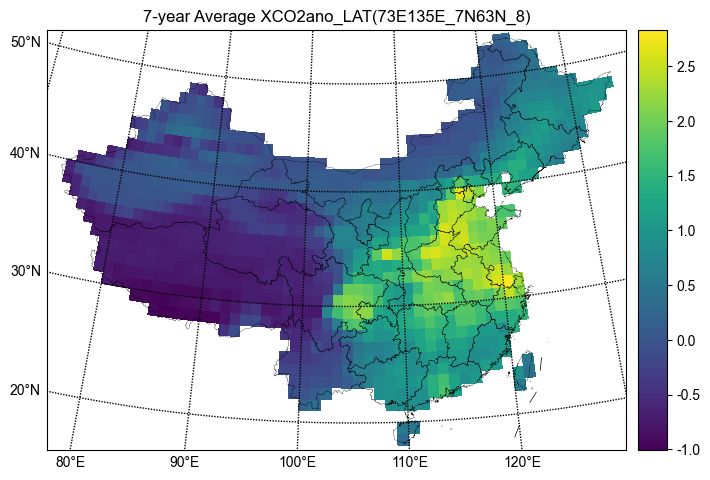

In [7]:
data = np.array([np.load(outPath.format("LAT_year_73E135E_7N63N_8")+f"MappingXCO2_{year}.npy") for year in range(2015, 2022)])
map_plot_surface(data.mean(axis=0), "viridis", None, None, f"7-year Average XCO2ano_LAT(73E135E_7N63N_8)", figsize=(8, 8))

# 仅中国区域的LAT生成测试

In [6]:
data_years = {year:np.array([read(f, mask=china) for f in files[year]]) for year in range(2015, 2022)}

def chn_lat_gen(lats: tuple, bandwidth: int, years=(2015, 2022), save_folder=None, inform=True):

    mkdir(outPath.format(save_folder))

    # 索引
    left = cnLeft
    right = cnRight
    bottom = int(lats[0]) + 90
    top = int(lats[1]) + 90  # 实际为加89， 加1用于索引和运算

    len_lon = right - left
    len_lat = top - bottom

    error_flag = False
    if len_lat % bandwidth != 0:  # 整除约束
        print(f"Error> Bandwidth:{bandwidth} doesn't exactly divide Length_of_Lats:{len_lat}.")
        error_flag = True
    if not (cnBottom>=bottom+bandwidth//2 and cnTop<=top-bandwidth//2):  # 底、顶端纬度带半约束
        print(f"Error> Latitude_range:({lats[0]},{lats[1]}) and Bandwidth:{bandwidth} don't conform to the constraint.")
        error_flag = True

    if error_flag:
        return 0.0

    num_bands = len_lat // bandwidth  # 纬度带数量

    anomaly = []
    if inform:
        print(f"Process (lats: {lats}; bandwidth: {bandwidth}; years: {years}) start.")

    for year in range(*years):
        data = data_years[year][:, bottom:top, left:right]  # 切片shape: (~365, lats, lons)
        num_days = data.shape[0]

        # 每日文件先变形为天数*纬度带数量*纬度带宽度*经度范围长度，获得一定个数纬度带的中值，shape: (~365, num_bands)
        medians = np.nanmedian(data.reshape(num_days, num_bands, bandwidth, len_lon), axis=(2, 3))
        medians_lat = np.linspace(bandwidth/2, len_lat-bandwidth/2, num_bands)  # shape: (num_bands,)
        f = interp1d(medians_lat, medians)
        # 顶部和底部各半个纬度带无法插值，奇偶纬度带长度通用
        to_interp = np.linspace(bandwidth//2+0.5, len_lat-bandwidth//2-0.5, len_lat-bandwidth//2*2)
        nan_rows = np.full((num_days, bandwidth//2), np.nan)  # 填充矩阵
        temp = f(to_interp)
        if True in np.isnan(temp):  # 边缘无法插值
            print(f"Error> Unable to interpolate edge grids.")
            return 0.0
        bck = np.broadcast_to(np.concatenate((nan_rows, f(to_interp), nan_rows), axis=1)[:, :, np.newaxis],
                              (num_days, len_lat, len_lon))  # shape: (n, 高, 宽)，插值、填充后广播到经度上

        global_map = np.full((180, 360), np.NaN)
        global_map[bottom:top, left:right] = np.nanmean(data - bck, axis=0)  # 填充至全球
        global_map[~china] = np.NaN
        anomaly.append(global_map)
        if save_folder:
            np.save(outPath.format(save_folder)+f"MappingXCO2_{year}.npy", global_map)

    # 计算与ODIAC之间的相关系数r
    num_years = years[1] - years[0]
    expand_china = np.expand_dims(china, axis=0).repeat(num_years, axis=0)
    anomaly = np.array(anomaly)[expand_china]
    odiac = odiac_dataset[years[0]-2015:years[1]-2015][expand_china]
    r = pd.DataFrame([anomaly, odiac]).T.corr().iloc[0, 1]
    if inform:
        print("Process completed.\n")

    return r


def better_func2(lat, bandwidth, num_bands):  # 起始经度纬度（左下角）、纬度带宽、纬度带长度（经度范围）、纬度带数量
    # lon<=cn_left, lon+bandlength>=cn_right, 
    lat_bottom = lat
    lat_top = lat+bandwidth*num_bands
    return chn_lat_gen((lat_bottom, lat_top), bandwidth, inform=False)

In [4]:
import math
import time

best_r = 0.0
best_params = None
t = time.time()

for bandwidth in range(5, 16):  # 纬度带大小5到15
    for lat in range(0, cn_bottom-bandwidth//2+1):  # 从赤道到最低纬度带一半
        num_bands = math.ceil((cn_top+bandwidth//2-lat)/bandwidth)  # 根据算式得到的纬度带数量
        new_r = better_func2(lat, bandwidth, num_bands)
        if new_r > best_r:
            best_r = new_r
            best_params = {"lat": lat,
                           "bandwidth": bandwidth,
                           "num_bands": num_bands}
    print(f"Time since pre-checkpoint: {time.time()-t}s")
    t = time.time()
    print(f"Checkpoint: best_r is {best_r} when params are {best_params}.")

Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Time since pre-checkpoint: 0.9941577911376953s
Checkpoint: best_r is 0.5318293826337477 when params are {'lat': 16, 'bandwidth': 5, 'num_bands': 8}.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate edge grids.
Error> Unable to interpolate ed

In [7]:
chn_lat_gen((9, 9+5*11), 11, save_folder="LAT_year_cn_9N64N_11")

Process (lats: (9, 64); bandwidth: 11; years: (2015, 2022)) start.
Process completed.



0.5454924024142451